<a href="https://colab.research.google.com/github/SamChuah/Kaggle_exercise/blob/master/Stanford_Dogs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import all python scripts to local folder
!cp drive/My\ Drive/Steven/*.py ./

In [2]:
# Download dataset
#!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
#!wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar

In [3]:
# Unzip downloaded files 
#!tar -xf images.tar
#!tar -xf lists.tar
#!rm *.tar

In [4]:
# Import dependencies
import time
import torch
import scipy.io
import numpy as np
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import resnet_model as model
import dataloader as DA
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [5]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
# Load train/test lists
test_mat = scipy.io.loadmat('test_list.mat')
train_mat = scipy.io.loadmat('train_list.mat')

In [7]:
train_list = train_mat['file_list'] 
test_list = test_mat['file_list']

In [8]:
train_classes = train_mat['labels']
test_classes = test_mat['labels']
train_classes -= 1
test_classes -= 1

In [9]:
new_train_list = []
new_test_list = [] 
for l in train_list:
  new_train_list.append((l[0][0]))

for l in test_list:
  new_test_list.append(l[0][0])

# Overwrite 
test_list = new_test_list
train_list = new_train_list

In [10]:
'''
# Convert ground truth labels from strings to ints
# Training set
train_breeds = []
train_classes = []

breed = -1

for path in train_list:
    train_breeds.append(path.split('/')[0].split('-')[1])

    if breed != path.split('/')[0].split('-')[1]:
      breed = path.split('/')[0].split('-')[1]

# Testing set
test_breeds = []
test_classes = []

breed = -1

for path in train_list:
    test_breeds.append(path.split('/')[0].split('-')[1])

    if breed != path.split('/')[0].split('-')[1]:
      breed = path.split('/')[0].split('-')[1]
'''

"\n# Convert ground truth labels from strings to ints\n# Training set\ntrain_breeds = []\ntrain_classes = []\n\nbreed = -1\n\nfor path in train_list:\n    train_breeds.append(path.split('/')[0].split('-')[1])\n\n    if breed != path.split('/')[0].split('-')[1]:\n      breed = path.split('/')[0].split('-')[1]\n\n# Testing set\ntest_breeds = []\ntest_classes = []\n\nbreed = -1\n\nfor path in train_list:\n    test_breeds.append(path.split('/')[0].split('-')[1])\n\n    if breed != path.split('/')[0].split('-')[1]:\n      breed = path.split('/')[0].split('-')[1]\n"

In [11]:
'''le = preprocessing.LabelEncoder()

le.fit(train_breeds)
train_classes = le.transform(train_breeds)
test_classes = le.transform(test_breeds)'''

'le = preprocessing.LabelEncoder()\n\nle.fit(train_breeds)\ntrain_classes = le.transform(train_breeds)\ntest_classes = le.transform(test_breeds)'

In [12]:
# Split train into train/validation
# trainX, testX, trainY, testY = train_test_split(train_list, train_classes-1, test_size=0.2)


(240, 320, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 3000 + 1) instead
  
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


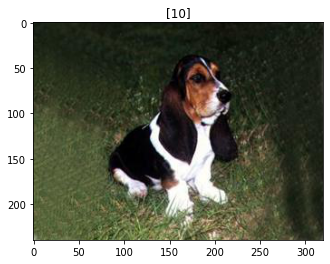

In [13]:
# Visualize input image and the label
idx = np.random.random_integers(0, 3000, 1)
path = train_list[idx.item()]
img = Image.open('Images/' + path)
'''
# img = transforms.CenterCrop(144)(img)
augment = transforms.Compose([
        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224)  # Image net standards
        ])
augment = transforms.Compose([
        transforms.RandomRotation(degrees=45),
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224)
        ])
img = augment(img)
'''
b = train_classes[idx.item()]
img = np.array(img)
plt.imshow(img)
plt.title(b)
print(img.shape)

In [14]:
# Define loss function. In this case, we will be using Cross-Entropy Loss

def loss_fnc(pred, label):
    pred_norm = F.softmax(pred, dim=1)  # B, C
    loss = -torch.sum(label*torch.log(pred_norm), dim=1)

    return torch.mean(loss)

In [15]:
# Training hyper-parameters:
batchsize = 128
learning_rate = 0.0003
epochs = 400

In [16]:
TrainImgLoader = torch.utils.data.DataLoader(DA.myImageFloder(train_list, train_classes, True),
                                             batch_size=batchsize, shuffle=True, num_workers=8, 
                                             drop_last=False)
TestImgLoader = torch.utils.data.DataLoader(DA.myImageFloder(test_list, test_classes, False), 
                                            batch_size=batchsize, shuffle=True, num_workers=8, 
                                            drop_last=False)

In [17]:
resnet = model.resnet18(pretrained=False)

if torch.cuda.is_available():
   resnet = resnet.cuda()
print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in resnet.parameters()])))

Number of model parameters: 698552


In [18]:
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.0)
loss_fnc = nn.CrossEntropyLoss()

In [19]:
# Calculate accuracy by finding max log probability

def calc_acc(pred, label):
    pred = F.softmax(pred, dim=1)
    _, pred = torch.max(pred, dim=1) # first output gives the max value in the row(not what we want), second output gives index of the highest val

    correct_labels = [p == l for p, l in zip(pred, label)]
    accuracy = torch.mean(torch.tensor(correct_labels, dtype=torch.float32)) #tensor must be float to calc average

    return accuracy*100

In [20]:
# Train
def train(img, label):
    resnet.train()
    if torch.cuda.is_available():
       img, label = img.cuda(), label.squeeze(1).cuda()
    
    #label = label.detach()
    optimizer.zero_grad()

    #for param in resnet.parameters():
    #    param.requires_grad = False

    #resnet.fc1.weight.requires_grad = True
    #resnet.fc1.bias.requires_grad = True

    pred = resnet(img)
    loss = loss_fnc(pred, label)

    loss.backward()
    optimizer.step()

    with torch.no_grad():
      acc = calc_acc(pred, label)

    return loss.data, acc.data

In [21]:
# Test 
def test(img, label):
    
    if torch.cuda.is_available():
       img, label = img.cuda(), label.squeeze(1).cuda()

    resnet.eval()
    with torch.no_grad():
        pred = resnet(img)
    
    loss = loss_fnc(pred, label)
    acc = calc_acc(pred, label)

    return loss.data, acc.data

In [22]:
len(TrainImgLoader)*batchsize
len(TestImgLoader)*batchsize

8704

In [ ]:
# Loop

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for e in range(epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train_acc = 0
    total_test_acc = 0

    for batch_idx, (img, label) in enumerate(TrainImgLoader):
        start_time = time.time()

        loss, acc = train(img, label)
        #print('[INFO] Iter: %d/%d  Loss: %.4f'%(batch_idx+1, len(TrainImgLoader), loss.item()))
        total_train_loss += loss
        total_train_acc += acc
    
    train_losses.append(total_train_loss/len(TrainImgLoader))
    train_accs.append(total_train_acc/len(TrainImgLoader))
    total_train_time = (time.time() - start_time)
    print('[INFO] Epochs: %d/%d  Train Loss: %.4f. Train Acc: %.3f  Time: %.3f'%(e+1, epochs, train_losses[e], train_accs[e], total_train_time))

    for batch_idx, (img, label) in enumerate(TestImgLoader):
        start_time = time.time()

        loss, acc = test(img, label)
        #print('[INFO] Iter: %d/%d  Loss: %.4f'%(batch_idx+1, len(TestImgLoader), loss.item()))
        total_test_loss += loss
        total_test_acc += acc
    
    test_losses.append(total_test_loss/len(TestImgLoader))
    test_accs.append(total_test_acc/len(TestImgLoader))
    total_test_time = (time.time() - start_time)
    print('[INFO] Epochs: %d/%d  Test Loss: %.4f  Test Acc: %.3f Time: %.3f'%(e+1, epochs, test_losses[e], test_accs[e], total_test_time))

    if e+1 % 10 == 0:
        torch.save({'state_dict':resnet.state_dict(),
                    'epoch': e+1}, 'checkpoint'+str(e+1)+'.pth')


[INFO] Epochs: 1/400  Train Loss: 4.7255. Train Acc: 2.083  Time: 0.393
[INFO] Epochs: 1/400  Test Loss: 4.6452  Test Acc: 2.746 Time: 0.181
[INFO] Epochs: 2/400  Train Loss: 4.5447. Train Acc: 3.590  Time: 0.398
[INFO] Epochs: 2/400  Test Loss: 4.5381  Test Acc: 4.274 Time: 0.187
[INFO] Epochs: 3/400  Train Loss: 4.4028. Train Acc: 5.355  Time: 0.396
[INFO] Epochs: 3/400  Test Loss: 4.5050  Test Acc: 4.216 Time: 0.189
[INFO] Epochs: 4/400  Train Loss: 4.2668. Train Acc: 6.948  Time: 0.388
[INFO] Epochs: 4/400  Test Loss: 4.2790  Test Acc: 6.342 Time: 0.193
[INFO] Epochs: 5/400  Train Loss: 4.1539. Train Acc: 8.458  Time: 0.397
[INFO] Epochs: 5/400  Test Loss: 4.2035  Test Acc: 7.652 Time: 0.210


In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses, label='Train loss')
plt.plot(np.arange(len(test_losses)), test_losses, label='Test loss')
plt.legend()

In [ ]:
torch.save(resnet.state_dict(), 'checkpoint.pth')
!cp checkpoint.pth ./drive/My\ Drive/Steven/

In [ ]:
img, label = next(iter(TrainImgLoader))

In [ ]:
Img = (img[0])
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)

std = np.reshape(std, (3,1,1))
mean = np.reshape(mean, (3,1,1))
Img = Img.mul(std).add(mean)

Img = transforms.ToPILImage()(Img)
plt.imshow(Img)